# Notebook 3: Model Comparison Study
Compares 10 regression models across the top descriptor sets.

**Models:** Linear Regression, Ridge, Lasso, ElasticNet, SVR, KNN, Decision Tree, Random Forest, XGBoost, TabNet

**Evaluation:** LOO R2, 5-Fold R2, MAE, RMSE + grid search tuning

**Input:** best_combo_0 through best_combo_5 CSVs

In [7]:
import numpy as np
import pandas as pd
import os
import glob
import warnings
import time
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

warnings.filterwarnings('ignore')

# Try importing TabNet
try:
    from pytorch_tabnet.tab_model import TabNetRegressor
    import torch
    TABNET_AVAILABLE = True
    print('TabNet available')
except ImportError:
    TABNET_AVAILABLE = False
    print('TabNet not available, will skip. Install: pip install pytorch-tabnet')

TabNet not available, will skip. Install: pip install pytorch-tabnet


In [8]:
# ============================================================
# PATHS
# ============================================================
BASE_DIR = r"C:\Users\AbCMS_Lab\Desktop\Keshav-DDP"
PARENT_DIR = os.path.join(BASE_DIR, "Weight-contribution", "contribution-model")
STUDY_DIR = os.path.join(PARENT_DIR, "best-descriptors-model-study")
os.makedirs(STUDY_DIR, exist_ok=True)

# Load all best_combo CSVs
csv_files = sorted(glob.glob(os.path.join(PARENT_DIR, "best_combo_*.csv")))
print(f"Found {len(csv_files)} CSVs:")
for f in csv_files:
    name = os.path.basename(f)
    df_tmp = pd.read_csv(f)
    feat = [c for c in df_tmp.columns if c not in ['uid','Formula','alpha_R']]
    print(f"  {name}: {len(df_tmp)} rows, {len(feat)} features -> {feat}")

Found 0 CSVs:


In [9]:
PARENT_DIR = STUDY_DIR  # CSVs are in the study folder
# Load all best_combo CSVs
csv_files = sorted(glob.glob(os.path.join(PARENT_DIR, "best_combo_*.csv")))
print(f"Found {len(csv_files)} CSVs:")
for f in csv_files:
    name = os.path.basename(f)
    df_tmp = pd.read_csv(f)
    feat = [c for c in df_tmp.columns if c not in ['uid','Formula','alpha_R']]
    print(f"  {name}: {len(df_tmp)} rows, {len(feat)} features -> {feat}")

Found 6 CSVs:
  best_combo_0_w10_radius_mean.csv: 99 rows, 3 features -> ['E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean']
  best_combo_1_w10_radius_mean_max_mass_max_Z.csv: 99 rows, 5 features -> ['E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'max_mass', 'max_Z']
  best_combo_2_w10_radius_mean_max_mass_max_Z4.csv: 99 rows, 5 features -> ['E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'max_mass', 'max_Z4']
  best_combo_3_w10_radius_mean_max_Z4_max_Z.csv: 99 rows, 5 features -> ['E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'max_Z4', 'max_Z']
  best_combo_4_w10_radius_mean_max_mass.csv: 99 rows, 4 features -> ['E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'max_mass']
  best_combo_5_w10_radius_mean_radius_diff.csv: 99 rows, 4 features -> ['E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'radius_diff']


In [10]:
# ============================================================
# MODEL DEFINITIONS WITH PARAM GRIDS
# ============================================================
NON_FEAT = {'uid', 'Formula', 'alpha_R'}

def get_models():
    models = {
        'LinearReg': {
            'model': LinearRegression(),
            'params': {},  # no tuning needed
            'scale': True,
        },
        'Ridge': {
            'model': Ridge(),
            'params': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
            'scale': True,
        },
        'Lasso': {
            'model': Lasso(max_iter=5000),
            'params': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
            'scale': True,
        },
        'ElasticNet': {
            'model': ElasticNet(max_iter=5000),
            'params': {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.2, 0.5, 0.8]},
            'scale': True,
        },
        'SVR': {
            'model': SVR(),
            'params': {'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 0.5], 'kernel': ['rbf', 'linear']},
            'scale': True,
        },
        'KNN': {
            'model': KNeighborsRegressor(),
            'params': {'n_neighbors': [3, 5, 7, 9, 11, 15], 'weights': ['uniform', 'distance']},
            'scale': True,
        },
        'DecisionTree': {
            'model': DecisionTreeRegressor(random_state=42),
            'params': {'max_depth': [2, 3, 4, 5, None], 'min_samples_split': [2, 5, 10]},
            'scale': False,
        },
        'RandomForest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {'n_estimators': [50, 100, 200], 'max_depth': [2, 3, 4, None], 'min_samples_split': [2, 5]},
            'scale': False,
        },
        'XGBoost': {
            'model': XGBRegressor(random_state=42, verbosity=0),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.05, 0.1, 0.2],
                'reg_alpha': [0, 0.5, 1.0],
                'reg_lambda': [0.5, 1.0, 2.0],
            },
            'scale': False,
        },
    }
    return models

print(f"Models defined: {list(get_models().keys())}")
if TABNET_AVAILABLE:
    print("+ TabNet (handled separately)")

Models defined: ['LinearReg', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'KNN', 'DecisionTree', 'RandomForest', 'XGBoost']


In [11]:
# ============================================================
# CORE: TUNE + EVALUATE EACH MODEL
# ============================================================

def tune_and_evaluate(X, y, model_name, model_obj, param_grid, scale=True):
    """
    1. Grid search with 5-fold CV to find best params
    2. LOO with best params
    3. 5-fold with best params
    Returns dict with all metrics.
    """
    n = len(y)
    result = {'model': model_name}
    
    # --- Grid Search ---
    if param_grid:
        gs = GridSearchCV(model_obj, param_grid, cv=5, scoring='r2', n_jobs=-1, refit=True)
        if scale:
            scaler = StandardScaler()
            X_s = scaler.fit_transform(X)
            gs.fit(X_s, y)
        else:
            gs.fit(X, y)
        best_params = gs.best_params_
        best_model = gs.best_estimator_
        result['best_params'] = str(best_params)
        result['grid_search_R2'] = gs.best_score_
    else:
        best_model = model_obj
        best_params = {}
        result['best_params'] = '{}'
        result['grid_search_R2'] = np.nan
    
    # --- LOO ---
    loo = LeaveOneOut()
    y_pred_loo = np.zeros(n)
    for train_idx, test_idx in loo.split(X):
        if scale:
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X[train_idx])
            X_te = scaler.transform(X[test_idx])
        else:
            X_tr, X_te = X[train_idx], X[test_idx]
        best_model.fit(X_tr, y[train_idx])
        y_pred_loo[test_idx] = best_model.predict(X_te)
    
    result['LOO_R2'] = r2_score(y, y_pred_loo)
    result['LOO_MAE'] = mean_absolute_error(y, y_pred_loo)
    result['LOO_RMSE'] = np.sqrt(mean_squared_error(y, y_pred_loo))
    result['y_pred_loo'] = y_pred_loo  # keep for plotting
    
    # --- 5-Fold ---
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_kf = np.zeros(n)
    for train_idx, test_idx in kf.split(X):
        if scale:
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X[train_idx])
            X_te = scaler.transform(X[test_idx])
        else:
            X_tr, X_te = X[train_idx], X[test_idx]
        best_model.fit(X_tr, y[train_idx])
        y_pred_kf[test_idx] = best_model.predict(X_te)
    
    result['KFold_R2'] = r2_score(y, y_pred_kf)
    result['KFold_MAE'] = mean_absolute_error(y, y_pred_kf)
    
    # --- Train R2 ---
    if scale:
        scaler = StandardScaler()
        X_s = scaler.fit_transform(X)
        best_model.fit(X_s, y)
        result['Train_R2'] = r2_score(y, best_model.predict(X_s))
    else:
        best_model.fit(X, y)
        result['Train_R2'] = r2_score(y, best_model.predict(X))
    
    return result


def run_tabnet(X, y):
    """TabNet with LOO and KFold."""
    if not TABNET_AVAILABLE:
        return None
    
    n = len(y)
    result = {'model': 'TabNet'}
    
    # LOO
    y_pred_loo = np.zeros(n)
    loo = LeaveOneOut()
    for train_idx, test_idx in loo.split(X):
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X[train_idx])
        X_te = scaler.transform(X[test_idx])
        
        model = TabNetRegressor(
            n_d=8, n_a=8, n_steps=3,
            gamma=1.5, lambda_sparse=1e-3,
            optimizer_params=dict(lr=0.02),
            scheduler_params={"step_size":20, "gamma":0.9},
            scheduler_fn=torch.optim.lr_scheduler.StepLR,
            verbose=0,
            seed=42,
        )
        model.fit(
            X_tr, y[train_idx].reshape(-1, 1),
            eval_set=[(X_te, y[test_idx].reshape(-1, 1))],
            max_epochs=200,
            patience=30,
            batch_size=32,
        )
        y_pred_loo[test_idx] = model.predict(X_te).flatten()
    
    result['LOO_R2'] = r2_score(y, y_pred_loo)
    result['LOO_MAE'] = mean_absolute_error(y, y_pred_loo)
    result['LOO_RMSE'] = np.sqrt(mean_squared_error(y, y_pred_loo))
    result['y_pred_loo'] = y_pred_loo
    
    # KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_kf = np.zeros(n)
    for train_idx, test_idx in kf.split(X):
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X[train_idx])
        X_te = scaler.transform(X[test_idx])
        model = TabNetRegressor(
            n_d=8, n_a=8, n_steps=3,
            gamma=1.5, lambda_sparse=1e-3,
            optimizer_params=dict(lr=0.02),
            scheduler_params={"step_size":20, "gamma":0.9},
            scheduler_fn=torch.optim.lr_scheduler.StepLR,
            verbose=0,
            seed=42,
        )
        model.fit(
            X_tr, y[train_idx].reshape(-1, 1),
            eval_set=[(X_te, y[test_idx].reshape(-1, 1))],
            max_epochs=200,
            patience=30,
            batch_size=32,
        )
        y_pred_kf[test_idx] = model.predict(X_te).flatten()
    
    result['KFold_R2'] = r2_score(y, y_pred_kf)
    result['KFold_MAE'] = mean_absolute_error(y, y_pred_kf)
    result['Train_R2'] = np.nan  # TabNet overfits by design
    result['best_params'] = 'n_d=8,n_a=8,n_steps=3,lr=0.02'
    result['grid_search_R2'] = np.nan
    
    return result

print("Functions defined.")

Functions defined.


In [12]:
# ============================================================
# RUN ALL MODELS ON ALL CSVs
# ============================================================
all_results = []

for csv_path in csv_files:
    csv_name = os.path.basename(csv_path)
    short_name = csv_name.replace('best_combo_','').replace('.csv','')
    
    df = pd.read_csv(csv_path)
    feat_cols = [c for c in df.columns if c not in NON_FEAT and df[c].dtype in ['float64','float32','int64','int32']]
    X = df[feat_cols].values
    y = df['alpha_R'].values
    valid = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X, y = X[valid], y[valid]
    
    print(f"\n{'='*70}")
    print(f"CSV: {csv_name} | n={len(y)}, features={len(feat_cols)}: {feat_cols}")
    print(f"{'='*70}")
    
    models = get_models()
    
    for mname, mconfig in models.items():
        t0 = time.time()
        print(f"  {mname:<15}", end="", flush=True)
        
        try:
            res = tune_and_evaluate(X, y, mname, mconfig['model'], mconfig['params'], mconfig['scale'])
            res['csv'] = csv_name
            res['short_csv'] = short_name
            res['n_features'] = len(feat_cols)
            res['features'] = feat_cols
            all_results.append(res)
            dt = time.time() - t0
            print(f"LOO R2={res['LOO_R2']:.3f}  KF R2={res['KFold_R2']:.3f}  MAE={res['LOO_MAE']:.3f}  ({dt:.1f}s)")
        except Exception as e:
            print(f"FAILED: {str(e)[:60]}")
    
    # TabNet
    if TABNET_AVAILABLE:
        t0 = time.time()
        print(f"  {'TabNet':<15}", end="", flush=True)
        try:
            res = run_tabnet(X, y)
            if res:
                res['csv'] = csv_name
                res['short_csv'] = short_name
                res['n_features'] = len(feat_cols)
                res['features'] = feat_cols
                all_results.append(res)
                dt = time.time() - t0
                print(f"LOO R2={res['LOO_R2']:.3f}  KF R2={res['KFold_R2']:.3f}  MAE={res['LOO_MAE']:.3f}  ({dt:.1f}s)")
        except Exception as e:
            print(f"FAILED: {str(e)[:60]}")

print(f"\n\nTotal runs: {len(all_results)}")


CSV: best_combo_0_w10_radius_mean.csv | n=99, features=3: ['E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean']
  LinearReg      LOO R2=0.018  KF R2=0.042  MAE=0.736  (0.1s)
  Ridge          LOO R2=0.021  KF R2=0.040  MAE=0.726  (2.3s)
  Lasso          LOO R2=0.017  KF R2=0.040  MAE=0.731  (1.0s)
  ElasticNet     LOO R2=0.018  KF R2=0.041  MAE=0.731  (0.1s)
  SVR            LOO R2=0.579  KF R2=0.523  MAE=0.425  (0.2s)
  KNN            LOO R2=0.249  KF R2=0.198  MAE=0.581  (0.1s)
  DecisionTree   LOO R2=0.495  KF R2=-0.032  MAE=0.493  (0.1s)
  RandomForest   LOO R2=0.552  KF R2=0.553  MAE=0.457  (11.5s)
  XGBoost        LOO R2=0.518  KF R2=0.505  MAE=0.496  (2.9s)

CSV: best_combo_1_w10_radius_mean_max_mass_max_Z.csv | n=99, features=5: ['E_pfrac_VBM', 'E_pfrac_CBM', 'radius_mean', 'max_mass', 'max_Z']
  LinearReg      LOO R2=-0.006  KF R2=0.001  MAE=0.740  (0.1s)
  Ridge          LOO R2=0.000  KF R2=0.002  MAE=0.735  (0.1s)
  Lasso          LOO R2=-0.021  KF R2=-0.024  MAE=0.749  (0.1s)
  Ela

In [13]:
# ============================================================
# MASTER RESULTS TABLE
# ============================================================
table_cols = ['csv', 'model', 'n_features', 'Train_R2', 'KFold_R2', 'LOO_R2', 'LOO_MAE', 'LOO_RMSE', 'best_params']
df_results = pd.DataFrame([{k: r.get(k) for k in table_cols} for r in all_results])
df_results = df_results.sort_values('LOO_R2', ascending=False)

# Clean CSV name for display
df_results['csv_short'] = df_results['csv'].str.replace('best_combo_','#').str.replace('.csv','')

print('=' * 120)
print('FULL RESULTS TABLE (sorted by LOO R2)')
print('=' * 120)
display_cols = ['csv_short', 'model', 'n_features', 'Train_R2', 'KFold_R2', 'LOO_R2', 'LOO_MAE', 'LOO_RMSE']
print(df_results[display_cols].to_string(index=False, float_format='%.3f'))

# Save
save_path = os.path.join(STUDY_DIR, 'full_results.csv')
df_results[display_cols + ['best_params']].to_csv(save_path, index=False)
print(f"\nSaved to {save_path}")

FULL RESULTS TABLE (sorted by LOO R2)
                         csv_short        model  n_features  Train_R2  KFold_R2  LOO_R2  LOO_MAE  LOO_RMSE
                #0_w10_radius_mean          SVR           3     0.693     0.523   0.579    0.425     0.620
    #5_w10_radius_mean_radius_diff RandomForest           4     0.932     0.491   0.561    0.463     0.633
                #0_w10_radius_mean RandomForest           3     0.938     0.553   0.552    0.457     0.640
       #4_w10_radius_mean_max_mass RandomForest           4     0.935     0.526   0.545    0.460     0.645
#2_w10_radius_mean_max_mass_max_Z4 RandomForest           5     0.933     0.523   0.537    0.464     0.651
 #1_w10_radius_mean_max_mass_max_Z RandomForest           5     0.933     0.522   0.537    0.464     0.651
   #3_w10_radius_mean_max_Z4_max_Z RandomForest           5     0.934     0.520   0.534    0.466     0.653
       #4_w10_radius_mean_max_mass      XGBoost           4     0.940     0.529   0.534    0.493     0.653

In [15]:
# ============================================================
# BEST MODEL PER CSV
# ============================================================
print('=' * 100)
print('BEST MODEL PER DESCRIPTOR SET')
print('=' * 100)
best_per_csv = df_results.loc[df_results.groupby('csv')['LOO_R2'].idxmax()]
best_per_csv = best_per_csv.sort_values('LOO_R2', ascending=False)
print(best_per_csv[display_cols].to_string(index=False, float_format='%.3f'))
print('\n')
print('=' * 100)
print('BEST DESCRIPTOR SET PER MODEL')
print('=' * 100)
best_per_model = df_results.loc[df_results.groupby('model')['LOO_R2'].idxmax()]
best_per_model = best_per_model.sort_values('LOO_R2', ascending=False)
print(best_per_model[display_cols].to_string(index=False, float_format='%.3f'))

BEST MODEL PER DESCRIPTOR SET
                         csv_short        model  n_features  Train_R2  KFold_R2  LOO_R2  LOO_MAE  LOO_RMSE
                #0_w10_radius_mean          SVR           3     0.693     0.523   0.579    0.425     0.620
    #5_w10_radius_mean_radius_diff RandomForest           4     0.932     0.491   0.561    0.463     0.633
       #4_w10_radius_mean_max_mass RandomForest           4     0.935     0.526   0.545    0.460     0.645
#2_w10_radius_mean_max_mass_max_Z4 RandomForest           5     0.933     0.523   0.537    0.464     0.651
 #1_w10_radius_mean_max_mass_max_Z RandomForest           5     0.933     0.522   0.537    0.464     0.651
   #3_w10_radius_mean_max_Z4_max_Z RandomForest           5     0.934     0.520   0.534    0.466     0.653


BEST DESCRIPTOR SET PER MODEL
                     csv_short        model  n_features  Train_R2  KFold_R2  LOO_R2  LOO_MAE  LOO_RMSE
            #0_w10_radius_mean          SVR           3     0.693     0.523   0.579   

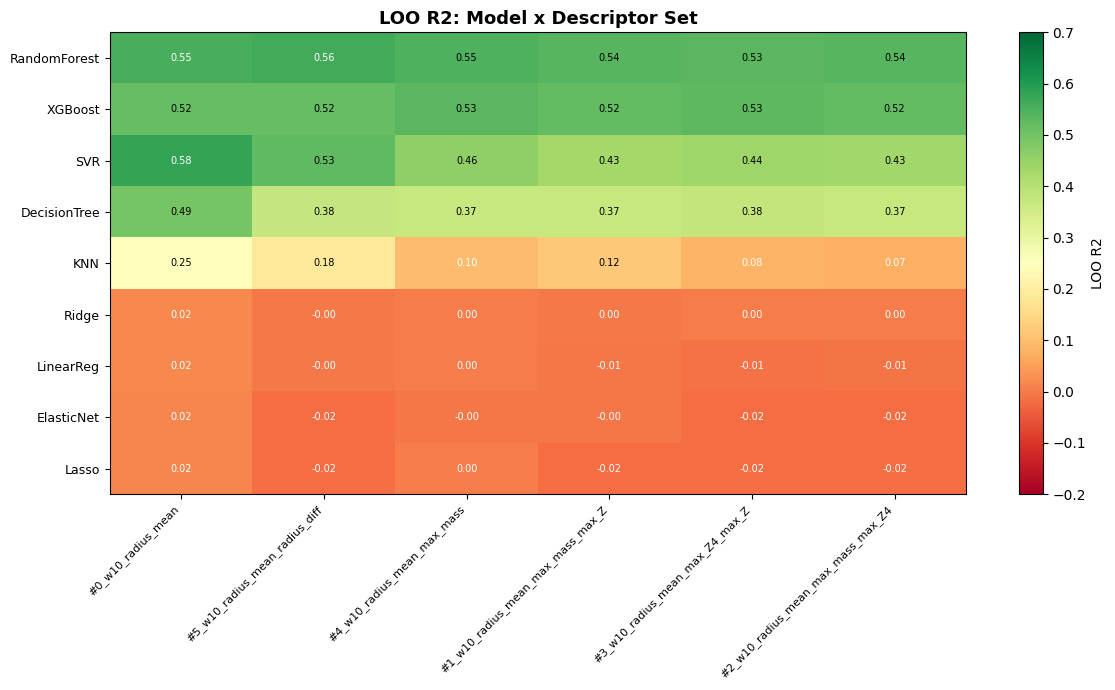

In [16]:
# ============================================================
# HEATMAP: Model x CSV -> LOO R2
# ============================================================
pivot = df_results.pivot_table(index='model', columns='csv_short', values='LOO_R2')

# Sort by mean R2
model_order = pivot.mean(axis=1).sort_values(ascending=False).index
csv_order = pivot.mean(axis=0).sort_values(ascending=False).index
pivot = pivot.loc[model_order, csv_order]

fig, ax = plt.subplots(figsize=(12, 7))
im = ax.imshow(pivot.values, cmap='RdYlGn', aspect='auto', vmin=-0.2, vmax=0.7)

ax.set_xticks(range(len(csv_order)))
ax.set_xticklabels(csv_order, rotation=45, ha='right', fontsize=8)
ax.set_yticks(range(len(model_order)))
ax.set_yticklabels(model_order, fontsize=9)

# Annotate
for i in range(len(model_order)):
    for j in range(len(csv_order)):
        val = pivot.values[i, j]
        if not np.isnan(val):
            color = 'white' if val < 0.1 or val > 0.55 else 'black'
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=7, color=color)

plt.colorbar(im, ax=ax, label='LOO R2')
ax.set_title('LOO R2: Model x Descriptor Set', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(STUDY_DIR, 'heatmap_r2.png'), dpi=150, bbox_inches='tight')
plt.show()

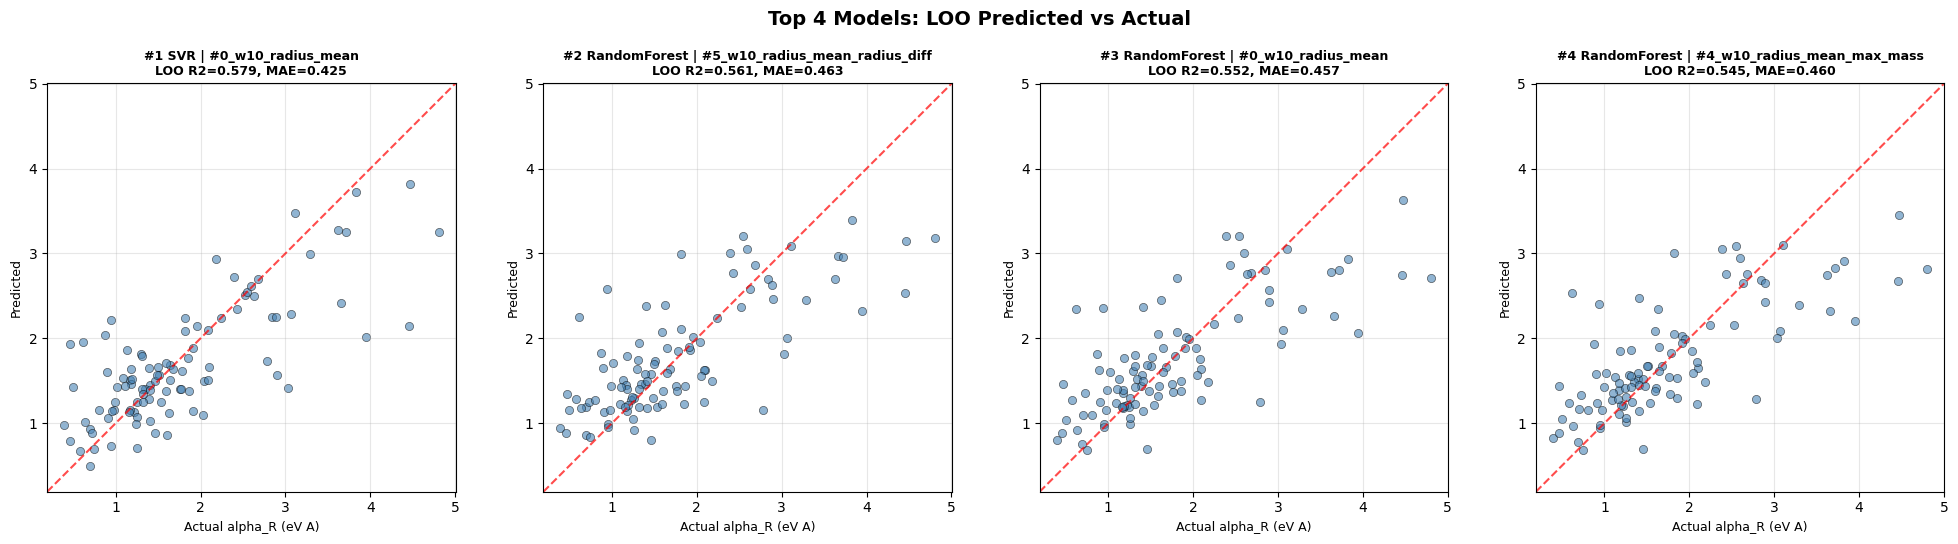

In [17]:
# ============================================================
# PRED vs ACTUAL: TOP 4 OVERALL MODELS
# ============================================================
top4 = df_results.nlargest(4, 'LOO_R2')

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, (_, row_info) in enumerate(top4.iterrows()):
    # Find the matching result with y_pred_loo
    match = [r for r in all_results if r['model'] == row_info['model'] and r['csv'] == row_info['csv']]
    if not match or 'y_pred_loo' not in match[0]:
        continue
    
    res = match[0]
    df_data = pd.read_csv(os.path.join(PARENT_DIR, res['csv']))
    y_actual = df_data['alpha_R'].values
    y_pred = res['y_pred_loo']
    
    # Handle size mismatch from NaN removal
    feat_cols = [c for c in res['features'] if c in df_data.columns]
    X_tmp = df_data[feat_cols].values
    valid = ~(np.isnan(X_tmp).any(axis=1) | np.isnan(y_actual))
    y_actual = y_actual[valid]
    
    ax = axes[idx]
    ax.scatter(y_actual, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5, s=35, c='steelblue')
    lims = [min(y_actual.min(), y_pred.min()) - 0.2, max(y_actual.max(), y_pred.max()) + 0.2]
    ax.plot(lims, lims, 'r--', lw=1.5, alpha=0.7)
    ax.set_xlabel('Actual alpha_R (eV A)', fontsize=9)
    ax.set_ylabel('Predicted', fontsize=9)
    
    csv_short = res['csv'].replace('best_combo_','#').replace('.csv','')
    ax.set_title(f"#{idx+1} {res['model']} | {csv_short}\nLOO R2={res['LOO_R2']:.3f}, MAE={res['LOO_MAE']:.3f}",
                 fontsize=9, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.suptitle('Top 4 Models: LOO Predicted vs Actual', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig(os.path.join(STUDY_DIR, 'top4_pred_vs_actual.png'), dpi=150, bbox_inches='tight')
plt.show()

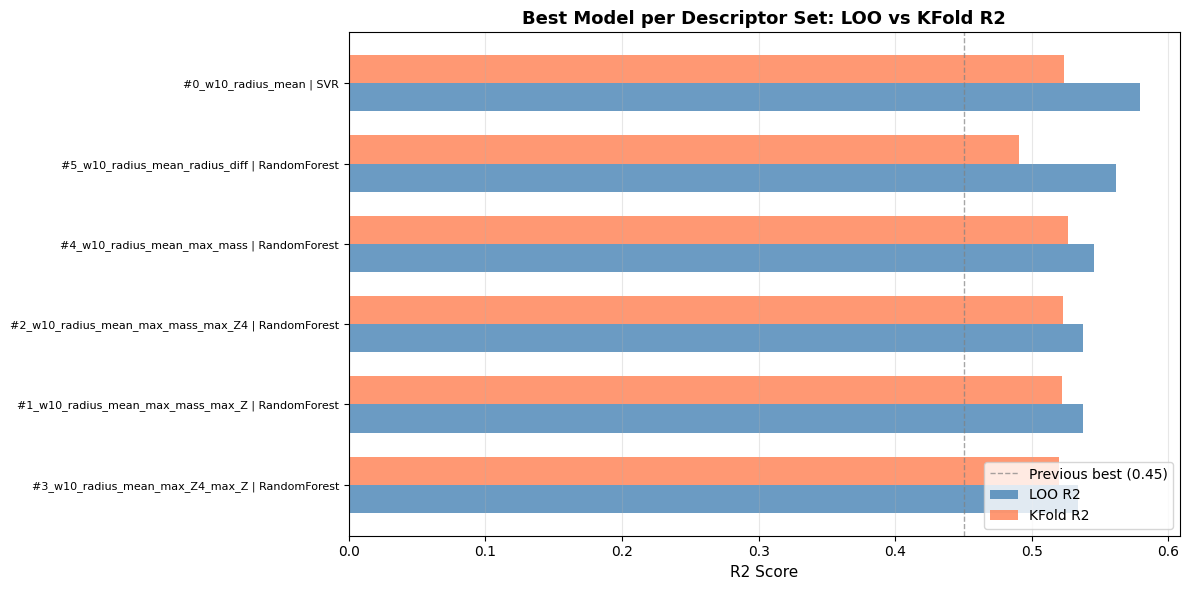

In [18]:
# ============================================================
# BAR CHART: LOO R2 vs KFold R2 for best model per CSV
# ============================================================
fig, ax = plt.subplots(figsize=(12, 6))

bpc = best_per_csv.sort_values('LOO_R2', ascending=True)
labels = bpc['csv_short'] + ' | ' + bpc['model']
y_pos = range(len(bpc))
width = 0.35

bars1 = ax.barh([p - width/2 for p in y_pos], bpc['LOO_R2'], width, color='steelblue', alpha=0.8, label='LOO R2')
bars2 = ax.barh([p + width/2 for p in y_pos], bpc['KFold_R2'], width, color='coral', alpha=0.8, label='KFold R2')

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=8)
ax.set_xlabel('R2 Score', fontsize=11)
ax.set_title('Best Model per Descriptor Set: LOO vs KFold R2', fontsize=13, fontweight='bold')
ax.axvline(x=0.45, color='gray', ls='--', lw=1, alpha=0.7, label='Previous best (0.45)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(STUDY_DIR, 'loo_vs_kfold.png'), dpi=150, bbox_inches='tight')
plt.show()

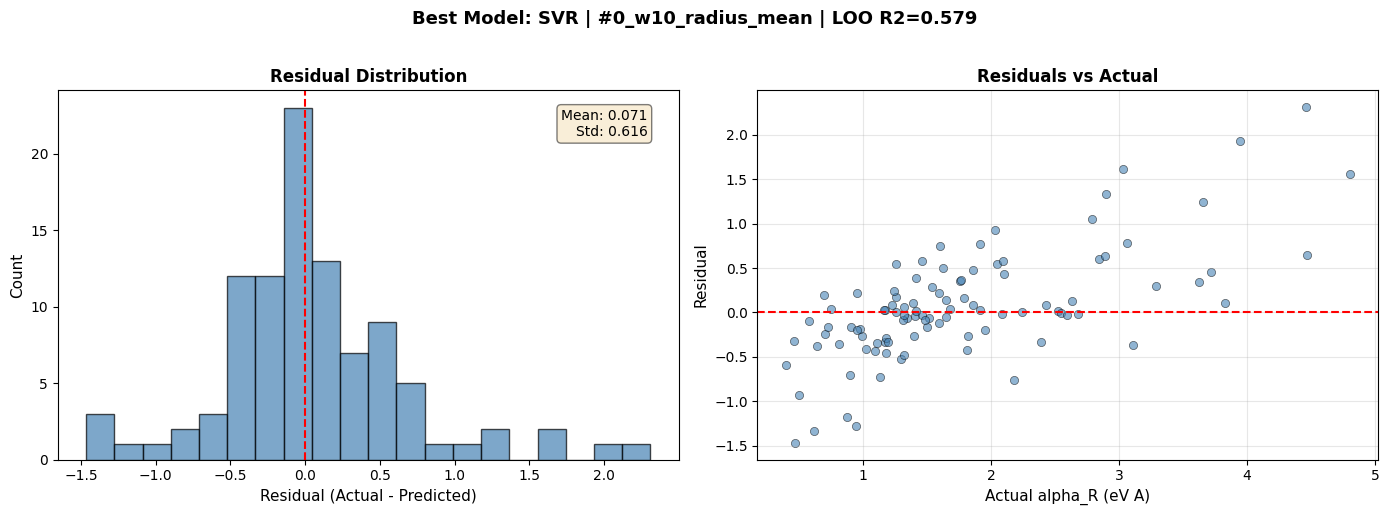

In [19]:
# ============================================================
# RESIDUAL DISTRIBUTION: BEST OVERALL MODEL
# ============================================================
best_overall = df_results.iloc[0]
best_match = [r for r in all_results if r['model'] == best_overall['model'] and r['csv'] == best_overall['csv']][0]

df_best = pd.read_csv(os.path.join(PARENT_DIR, best_match['csv']))
feat_cols = [c for c in best_match['features'] if c in df_best.columns]
X_tmp = df_best[feat_cols].values
y_actual = df_best['alpha_R'].values
valid = ~(np.isnan(X_tmp).any(axis=1) | np.isnan(y_actual))
y_actual = y_actual[valid]
y_pred = best_match['y_pred_loo']
residuals = y_actual - y_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Residual histogram
ax1.hist(residuals, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='red', ls='--', lw=1.5)
ax1.set_xlabel('Residual (Actual - Predicted)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Residual Distribution', fontsize=12, fontweight='bold')
ax1.text(0.95, 0.95, f'Mean: {residuals.mean():.3f}\nStd: {residuals.std():.3f}',
         transform=ax1.transAxes, va='top', ha='right', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Residual vs actual
ax2.scatter(y_actual, residuals, alpha=0.6, edgecolors='black', linewidth=0.5, s=35, c='steelblue')
ax2.axhline(y=0, color='red', ls='--', lw=1.5)
ax2.set_xlabel('Actual alpha_R (eV A)', fontsize=11)
ax2.set_ylabel('Residual', fontsize=11)
ax2.set_title('Residuals vs Actual', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

csv_short = best_match['csv'].replace('best_combo_','#').replace('.csv','')
fig.suptitle(f"Best Model: {best_match['model']} | {csv_short} | LOO R2={best_match['LOO_R2']:.3f}",
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(STUDY_DIR, 'residuals_best.png'), dpi=150, bbox_inches='tight')
plt.show()

In [20]:
# ============================================================
# FINAL SUMMARY
# ============================================================
print('\n' + '='*100)
print('FINAL SUMMARY')
print('='*100)

top5_overall = df_results.nlargest(5, 'LOO_R2')
print('\nTop 5 Overall (Model + Descriptor):')
print('-'*100)
for i, (_, r) in enumerate(top5_overall.iterrows()):
    csv_s = r['csv'].replace('best_combo_','#').replace('.csv','')
    print(f"  #{i+1}: {r['model']:<15} | {csv_s:<45} | LOO R2={r['LOO_R2']:.3f} | KF R2={r['KFold_R2']:.3f} | MAE={r['LOO_MAE']:.3f}")

print(f"\n{'='*100}")
print(f"Previous baseline: R2 = 0.45 (elemental features only)")
print(f"Best from this study: R2 = {df_results['LOO_R2'].max():.3f}")
print(f"Improvement: +{df_results['LOO_R2'].max() - 0.45:.3f}")
print(f"{'='*100}")


FINAL SUMMARY

Top 5 Overall (Model + Descriptor):
----------------------------------------------------------------------------------------------------
  #1: SVR             | #0_w10_radius_mean                            | LOO R2=0.579 | KF R2=0.523 | MAE=0.425
  #2: RandomForest    | #5_w10_radius_mean_radius_diff                | LOO R2=0.561 | KF R2=0.491 | MAE=0.463
  #3: RandomForest    | #0_w10_radius_mean                            | LOO R2=0.552 | KF R2=0.553 | MAE=0.457
  #4: RandomForest    | #4_w10_radius_mean_max_mass                   | LOO R2=0.545 | KF R2=0.526 | MAE=0.460
  #5: RandomForest    | #2_w10_radius_mean_max_mass_max_Z4            | LOO R2=0.537 | KF R2=0.523 | MAE=0.464

Previous baseline: R2 = 0.45 (elemental features only)
Best from this study: R2 = 0.579
Improvement: +0.129
